In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pandas as pd

In [2]:
folder_path = r'C:\Users\daV\Documents\ZHAW\HS 2024\dPoDL\dPoDL\experiments\filtered-search\cnns\cifar10\categorical'
sequences = []

# Load all CSVs and extract sequences of loss values
for filename in [i for i in os.listdir(folder_path) if i.endswith(".csv")]:
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            data = pd.read_csv(file_path)
            if len(data) >= 3: 
                values_temp = data['Loss'].values
                if max(values_temp) < 2 and min(values_temp) > 0:  # make sure data makes sense
                    sequences.append(values_temp)
        except Exception as e:
            print(e, filename)


### Conditions when to stop:
- values start to increase -> max increase allowed: 0.005 for 3 epochs straight
- values don't decrease sufficiently -> min decrease: 0.003

In [33]:
def find_stabilization_point(
    sequence,
    window=5,
    slope_threshold=0.005,
    curvature_threshold=0.05,
    patience=1,
    oscillation_tolerance=0.001,
    increasing_trend_threshold=0.01,
    flat_change_threshold=0.003 
):
    if len(sequence) < window * 2:
        return float("inf")

    # Smooth the sequence using a moving average
    smoothed_sequence = np.convolve(sequence, np.ones(window) / window, mode='valid')

    # Calculate slopes and curvatures
    slopes = np.diff(smoothed_sequence) / smoothed_sequence[:-1]
    curvatures = np.diff(slopes)

    stabilization_count = 0
    for i in range(len(slopes) - window):
        recent_slopes = slopes[i: i + window]
        recent_curvatures = curvatures[i: i + window - 1]

        # Stabilization conditions
        is_stabilized = (
            np.all(np.abs(recent_slopes) < slope_threshold) and
            np.all(np.abs(recent_curvatures) < curvature_threshold)
        )

        # Oscillation detection
        recent_values = smoothed_sequence[i: i + window]
        oscillation_range = np.ptp(recent_values)
        is_oscillating = oscillation_range < oscillation_tolerance

        # Increasing trend detection
        has_increasing_trend = np.all(recent_slopes > increasing_trend_threshold)

        # Flat change detection
        flat_change = np.abs(smoothed_sequence[i + window - 1] - smoothed_sequence[i]) < flat_change_threshold

        if is_stabilized or is_oscillating or flat_change:
            stabilization_count += 1
            if stabilization_count >= patience:
                return i + window
        elif has_increasing_trend:
            return i + window
        else:
            stabilization_count = 0

    return float("inf")



# Example usage:
random.seed(42)
for sequence in random.sample(sequences, 100):
    stable_point = find_stabilization_point(sequence)
    plt.plot(sequence)
    if stable_point < len(sequence):
        plt.axvline(x=stable_point, color='r', linestyle='--', label='stable_point')
    plt.show()


NameError: name 'd' is not defined

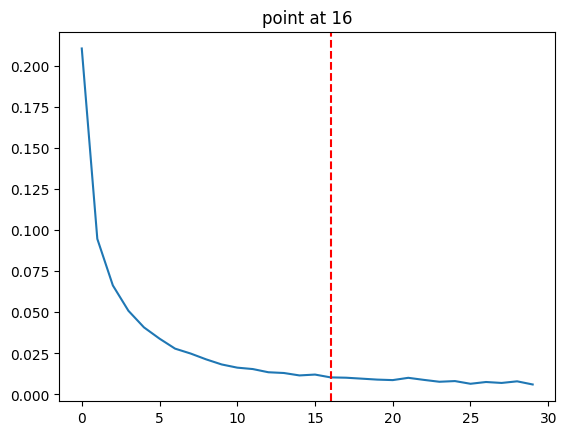

C:\Users\daV\AppData\Local\Temp\ipykernel_14196\654891500.py:18: RuntimeWarning: invalid value encountered in divide
  slopes = np.diff(smoothed_sequence) / smoothed_sequence[:-1]


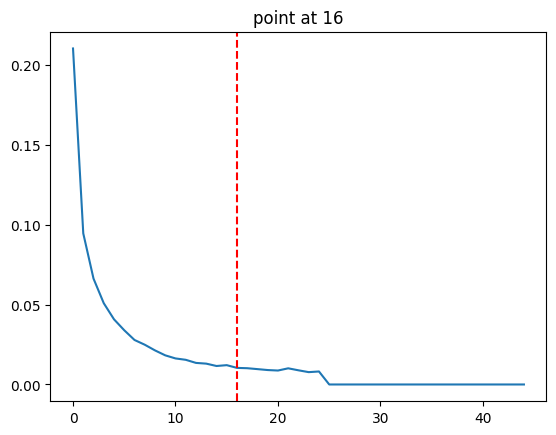

In [35]:
l = [0.21055838465690613, 0.09468044340610504, 0.06634636968374252, 0.050932031124830246, 0.04082872346043587, 0.033973999321460724, 0.027891580015420914, 0.024912890046834946, 0.021354248747229576, 0.018257126212120056, 0.01632021553814411, 0.015460487455129623, 0.01351927686482668, 0.013060691766440868, 0.01158374734222889, 0.012108856812119484, 0.010395072400569916, 0.010194196365773678, 0.009623885154724121, 0.009044128470122814, 0.008739764802157879, 0.010129030793905258, 0.008878235705196857, 0.007730330806225538, 0.008148149587213993, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ll = [0.21055838465690613, 0.09468044340610504, 0.06634636968374252, 0.050932031124830246, 0.04082872346043587, 0.033973999321460724, 0.027891580015420914, 0.024912890046834946, 0.021354248747229576, 0.018257126212120056, 0.01632021553814411, 0.015460487455129623, 0.01351927686482668, 0.013060691766440868, 0.01158374734222889, 0.012108856812119484, 0.010395072400569916, 0.010194196365773678, 0.009623885154724121, 0.009044128470122814, 0.008739764802157879, 0.010129030793905258, 0.008878235705196857, 0.007730330806225538, 0.008148149587213993, 0.006503025535494089, 0.0075839813798666, 0.007009278051555157, 0.007993829436600208, 0.006076819729059935]
for sequence in (ll, l):
    stable_point = find_stabilization_point(
    sequence
)
    plt.plot(sequence)
    plt.title(f"point at {stable_point}")
    if stable_point < len(sequence):
        plt.axvline(x=stable_point, color='r', linestyle='--', label='stable_point')
    plt.show()

# to-do
- placement of report, e.g. double descent erwähnen, modular anwendung auch für zukunft andere anwendungsfälle
- vortrag helmut letzte Januarwoche im IDP
- mechanismus dass predicted "halluzinogen" wenn genug confident
- zusammensetzen der teile!
- report beginnen zu schreiben

In [ ]:
MIN_DECREASE = -0.001
MAX_INCREASE = 0.0005
WINDOW = 20
SLACK_RATE_DECREASE, SLACK_RATE_INCREASE = 0.3, 0.5
SLACK_RATE_DECREASE, SLACK_RATE_INCREASE = SLACK_RATE_DECREASE * WINDOW, SLACK_RATE_INCREASE * WINDOW


def find_stabilization_point(sequence):
    """
    Identifies the point at which the sequence stops significantly decreasing.

    :param sequence: List of float values (the sequence to analyze)
    :return: The index of the first value where the sequence stops significantly decreasing, or None if not found
    """

    if len(sequence) < 2:
        return float("inf")  # A sequence with less than 2 values can't have a significant decrease

    for i in range(WINDOW, len(sequence)):
        s = sequence[i - WINDOW: i]
        if any([s[j+1] < 0.25 * s[0] for j in range(len(s) - 1) ]):  # if any of the following values is smaller than 60% of start value, no we declare no point was found
            return float("inf")
    

    changes = []  # List to track the relative changes in values
    for i in range(1, len(sequence)):
        change = (sequence[i] - sequence[i - 1]) / abs(sequence[i - 1])
        changes.append(change)

    # Check if consecutive changes are consistently smaller than the threshold
    for i in range(WINDOW, len(changes)):
        # Consider the last few changes for oscillation detection
        # check for increasing behaviour:
        s = sequence[i - WINDOW: i]
        condition1 = not any(0.5 * s[0] > [s[j+1]  for j in range(len(s) - 1) ])  # if any of the following values is smaller than 50% of start value, we declare no point was found
        condition1 = True
        if condition1 and [change > MAX_INCREASE for change in changes[i - WINDOW: i]].count(True) >= SLACK_RATE_INCREASE: 
            return i - WINDOW

        # check for decreasing behaviour:
        if condition1 and [change > MIN_DECREASE for change in changes[i - WINDOW: i]].count(True) >= SLACK_RATE_DECREASE:
            return i

    return float("inf")  # No stabilization point found
